In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import cv2
import os
import glob
from sklearn.model_selection import train_test_split
from multiprocessing import cpu_count, Pool
from functools import partial
import pickle

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
annotations_path='../FDDB-folds/'
images_path = '../images/'
out_path = '../final_positives/'

annotations = open(annotations_path+'FDDB-annotations.txt').read().split('\n')

i=0
cnt2 = 0
bar = tqdm(total=len(annotations))
while i<len(annotations) and cnt2<1500:
    if os.path.isfile(images_path+annotations[i]+'.jpg'):
        count = int(annotations[i+1])
        j=1
        while j<=count:
            dat = annotations[i+j+1].split(' ')[:-2]
            dat = [int(float(x)) for x in dat]
            img = cv2.imread(images_path+annotations[i]+'.jpg',0)
            new_img = img[max(dat[4]-dat[0]-10,0):dat[4]+dat[0]+10, max(dat[3]-dat[1]-10,0):dat[3]+dat[1]+10]
            cv2.imwrite(out_path+str(cnt2)+'.jpg', cv2.resize(new_img,(19,19)))
            cnt2+=1
            j+=1
        i+=j
        bar.update(j)
    i+=1
    bar.update(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [2]:
def get_haar_features(window_size):
    haar_features = []
    types = [(1,2), (2,1), (1,3), (3,1)]
    total = 0
    for cur_type in types:
        init_height = cur_type[0]
        init_width = cur_type[1]
        for cur_width in range(init_width, window_size+1, init_width):
            for cur_height in range(init_height, window_size+1, init_height):
                for pos_x in range(0,window_size-cur_width+1):
                    for pos_y in range(0,window_size-cur_height+1):
                        whites = []
                        blacks = []
                        total+=1
                        if cur_type == (1,2):
                            whites.append([(pos_x,pos_y),(pos_x+(cur_width//2)-1, pos_y+cur_height-1)])
                            blacks.append([(pos_x+(cur_width//2),pos_y),(pos_x+cur_width-1, pos_y+cur_height-1)])
                        if cur_type == (2,1):
                            whites.append([(pos_x,pos_y),(pos_x+cur_width-1, pos_y+(cur_height//2)-1)])
                            blacks.append([(pos_x,pos_y+(cur_height//2)),(pos_x+cur_width-1, pos_y+cur_height-1)])
                        if cur_type == (1,3):
                            whites.append([(pos_x,pos_y),(pos_x+(cur_width//3)-1, pos_y+cur_height-1)])
                            blacks.append([(pos_x+(cur_width//3),pos_y),(pos_x+2*(cur_width)//3-1, pos_y+cur_height-1)])
                            whites.append([(pos_x+2*(cur_width)//3,pos_y),(pos_x+cur_width-1, pos_y+cur_height-1)])
                        if cur_type == (3,1):
                            whites.append([(pos_x,pos_y),(pos_x+cur_width-1, pos_y+(cur_height//3)-1)])
                            blacks.append([(pos_x,pos_y+(cur_height//3)),(pos_x+cur_width-1, pos_y+2*(cur_height//3)-1)])
                            whites.append([(pos_x,pos_y+2*(cur_height//3)),(pos_x+cur_width-1, pos_y+cur_height-1)])
                        if cur_type == (2,2):
                            whites.append([(pos_x,pos_y),(pos_x+(cur_width//2)-1, pos_y+(cur_height//2)-1)])
                            blacks.append([(pos_x+(cur_width//2),pos_y),(pos_x+cur_width-1, pos_y+(cur_height//2)-1)])
                            blacks.append([(pos_x,pos_y+(cur_height//2)),(pos_x+(cur_width//2)-1, pos_y+cur_height-1)])
                            whites.append([(pos_x+(cur_width//2),pos_y+(cur_height//2)),(pos_x+cur_width-1, pos_y+cur_height-1)])
                        
                        haar_features.append([whites,blacks])
                        # haar_features.append([blacks,whites])

    return haar_features

haar_features = get_haar_features(19)
print(len(haar_features))

55860


In [3]:
def get_integral_img(img):
    img = img.astype('int32')
    int_img = np.zeros_like(img, dtype='int32')
    sum = img[0].copy().astype('int32')
    int_img[0,:]=sum 
    for i in range(1,img.shape[0]):
        sum += img[i]
        int_img[i]=sum
    img = int_img.copy()
    sum = img[:,0].copy()
    for i in range(1,img.shape[0]):
        int_img[:,i]+=sum
        sum += img[:,i]

    return int_img

def get_sum(img, tr, bl):
    x1,x2,y1,y2 = tr[0],bl[0],tr[1],bl[1]
    sum = int(img[x2,y2])
    if x1>0 and y1>0:
        sum+=int(img[x1-1,y1-1])
    if y1>0:
        sum-=int(img[x2,y1-1])
    if x1>0:
        sum-=int(img[x1-1,y2])
    
    return sum

def apply_feature(img, whites, blacks):
    feature_applied = 0
    for rect in whites:
        feature_applied += get_sum(img, rect[0], rect[1])
    for rect in blacks:
        feature_applied -= get_sum(img, rect[0], rect[1])
    return feature_applied
 

1472
640


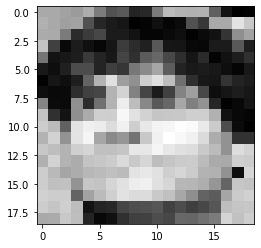

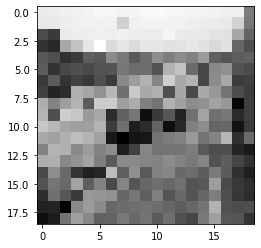

In [4]:
positives_path = '../final_positives/*'
negatives_path = '../dataset/SUN_data/train/*/*'

files = glob.glob('/content/drive/MyDrive/assignment-4-vinaykumartadepall/final_positives/*')
positives = [cv2.imread(f,0) for f in files]
print(len(positives))

files = glob.glob(negatives_path)
negatives = [cv2.resize(cv2.imread(f,0).astype('float'), (19,19)) for f in files]
print(len(negatives))

plt.imshow(positives[100], cmap=plt.get_cmap('gray'))
plt.show()
plt.imshow(negatives[523], cmap=plt.get_cmap('gray'))
plt.show()

In [6]:
class weak_classifier():
    def __init__(self, feature):
        self.whites = feature[0]
        self.blacks = feature[1]
        self.threshold = 0
        self.polarity = 1
        self.alpha = None
    
    def train(self, feature_vals, labels, weights):
        total_pos = np.sum(weights[labels==1])
        total_neg = np.sum(weights[labels==0])
        applied_feature = sorted(zip(weights, feature_vals, labels), key=lambda x: x[1])
        pos_seen, neg_seen = 0, 0
        pos_weights, neg_weights = 0, 0
        min_error, best_feature, best_threshold, best_polarity = float('inf'), None, None, None
        for w, f, label in applied_feature:
            error = min(neg_weights + total_pos - pos_weights, pos_weights + total_neg - neg_weights)
            if error < min_error:
                min_error = error
                # best_feature = features[index]
                best_threshold = f
                best_polarity = 1 if pos_seen > neg_seen else -1
            if label == 1:
                pos_seen += 1
                pos_weights += w
            else:
                neg_seen += 1
                neg_weights += w
        self.threshold = best_threshold
        self.polarity = best_polarity


    
    def classify(self, integral_image):
        feature_applied = apply_feature(integral_image, self.whites, self.blacks)        
        a = self.polarity * feature_applied
        b = self.polarity * self.threshold
        if self.alpha:
            return self.alpha*np.less(a, b).astype(int)
        return np.less(a, b).astype(int)

class adaboost():
    def __init__(self):
        # pass
        self.best_classifiers = []
        self.alphas = []
    
    def train(self,images, labels, features_applied, features, T):
        # features = features[:10]
        weights = np.zeros(labels.shape)
        num_pos = np.sum(labels)
        num_neg = np.sum(1-labels)
        weights[labels==1] = 1.0/num_pos
        weights[labels==0] = 1.0/num_neg

        integral_images = [get_integral_img(img) for img in images]
        for t in range(T):
            weights /= np.sum(weights)

            errors = np.zeros(len(features))
            classifiers = []
            for i in tqdm(range(len(features))):
                feature = features[i]
                cur_classifier = weak_classifier(feature=feature)
                cur_classifier.train(features_applied[i], labels, weights)
                classifiers.append(cur_classifier)
                errors[i] = np.sum(np.array([weights[j]*int(cur_classifier.classify(integral_images[j])!=labels[j]) for j in range(len(integral_images))]))
            
            best_idx = np.argmin(errors)
            best_err = errors[best_idx]
            best_classifier = classifiers[best_idx]
 
            beta = best_err/(1.0-best_err)
            not_matched = np.array([best_classifier.classify(integral_images[i])!=labels[i] for i in range(len(integral_images))])
            weights = np.multiply(weights, beta**(1-not_matched))
            alpha = np.log(1.0/(beta+1e-8))
            self.alphas.append(alpha)
            best_classifier.alpha = alpha
            self.best_classifiers.append(best_classifier)

            print("Error {} = {}".format(t,best_err))
            print("Matched {} outof {}".format(np.sum(not_matched==0), len(not_matched)))
        return self.best_classifiers, self.alphas
    
    def classify(self,image):
        class_pred = sum([clf.alpha * (1 if clf.classify(image)>0 else -1) for clf in self.best_classifiers[:]])
        return class_pred>0

    def evaluate(self, images, labels, feats):
        integral_images = [get_integral_img(img) for img in images]
        labels_pred = np.zeros_like(labels)
        # for clf in self.best_classifiers:
        #     print(clf.alpha)
        for i,img in enumerate(integral_images):
            labels_pred[i] = self.classify(img) #class_pred>0
        
        return labels_pred

class cascaded():
    def __init__(self, layers):
        self.layers = layers
        self.classifiers = []
    
    def train(self,images, labels, features):
        images = np.array(images)
        if not os.path.isfile('../features_applied.npy'):
            features_applied = np.zeros((len(features), len(images)))
            for i in tqdm(range(len(features))):
                f = features[i]
                features_applied[i] = np.array(list(map(lambda x: apply_feature(x, f[0], f[1]), integral_images)))
            np.save('../features_applied.npy', features_applied)
        else:
            features_applied = np.load('../features_applied.npy')
        # features = features[:10]
        # features_applied = features_applied[:10]
        print(len(features))
        # train_idxs = np.ones_like(labels_pred)
        pos_indices = np.array(np.where(labels==1))[0]
        neg_indices = np.array(np.where(labels==0))[0]
        for layer,t in enumerate(self.layers):
            cur_indices = np.concatenate((pos_indices, neg_indices))

            cur_classifier = adaboost()
            cur_classifier.train(images[cur_indices],labels[cur_indices],features_applied[:,cur_indices],features,t)
            self.classifiers.append(cur_classifier)
            fps = []
            for i in neg_indices:
                if self.classify(get_integral_img(images[i])) == 1:
                    fps.append(i)
            neg_indices = np.array(fps)
        
    def classify(self, image):

        for clf in self.classifiers:
            if clf.classify(image)==0:
                return 0
        return 1
    
    def evaluate(self, images, labels, feats):
        integral_images = [get_integral_img(img) for img in images]
        labels_pred = np.zeros_like(labels)
        for i,img in enumerate(integral_images):
            labels_pred[i] = self.classify(img)         
        return labels_pred


In [54]:
positives1 = positives[:640]
negatives1 = negatives[:640]
p_train, p_test = train_test_split(positives1, test_size=0.2, random_state=2)
n_train, n_test = train_test_split(negatives1, test_size=0.2, random_state=2)
images_train = p_train+n_train
images_test = p_test+n_test
labels_train = np.zeros(len(images_train))
labels_train[:len(p_train)]=1
labels_test = np.zeros(len(images_test))
labels_test[:len(p_test)]=1

# classifier = adaboost()
forced = 0
classifier = cascaded((1,5))
if os.path.isfile('../cascaded_classifier.pkl') and not forced:
    print("Loading saved classifier....")
    with open('../cascaded_classifier.pkl', 'rb') as f:
        classifier = pickle.load(f)
    
    labels_pred = classifier.evaluate(images_test, labels_test, haar_features)
    

else:
    print("Training the classifier.....")
    classifier.train(images_train, labels_train, haar_features)
    with open('../cascaded_classifier.pkl', 'wb') as f:
        pickle.dump(classifier, f, pickle.HIGHEST_PROTOCOL)
    labels_pred = classifier.evaluate(images_test, labels_test, haar_features)

Loading saved classifier....


In [55]:
errs = np.abs(labels_pred - labels_test)
print("Classified {} correctly out of {}".format(np.sum(errs==0), len(errs)))
print("Accuracy = {}".format(np.sum(errs==0)/len(errs)))

total_positives = np.sum(labels_test==1)
total_negatives = np.sum(labels_test==0)
tp = np.sum(errs[labels_test==1]==0)
tn = np.sum(errs[labels_test==0]==0)
fn = np.sum(errs[labels_test==1]==1)
fp = np.sum(errs[labels_test==0]==1)

print("True positive rate = {}\nFalse positive rate = {}\nTrue negative rate = {}\nFalse negative rate = {}".format(tp/total_positives,fp/total_positives,tn/total_negatives,fn/total_negatives))

Classified 200 correctly out of 256
Accuracy = 0.78125
True positive rate = 0.6640625
False positive rate = 0.1015625
True negative rate = 0.8984375
False negative rate = 0.3359375


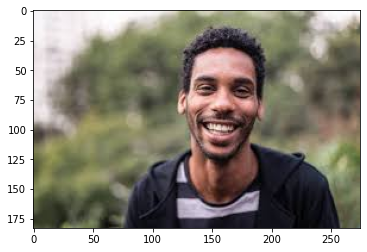

(183, 275, 3)


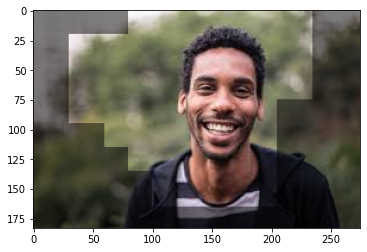

0


In [56]:
path = '../sample.jpeg'
img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
# print(img.shape)
# img[:,3]=0.1
plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.show()
mask = np.ones((img.shape[0],img.shape[1]))
img//=2

window_size = 75
stride = 10
print(img.shape)

cnt = 0
for i in range(0,img.shape[0]-window_size,stride):
    for j in range(0,img.shape[1]-window_size,stride):
        cur_image = cv2.cvtColor(cv2.resize(img[i:i+window_size, j:j+wind            # class_pred = sum([clf.alpha * (1 if clf.classify(img)>0 else -1 for clf in self.best_classifiers[:]])
ow_size], (19,19)), cv2.COLOR_RGB2GRAY)
        face_there = classifier.classify(get_integral_img(cur_image))
        if face_there:
            mask[i:i+window_size, j:j+window_size]=2
            # print("hurray")

for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if mask[i,j]==2:
            img[i,j]*=2

plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.show()

print(cnt)

# The brighter part is detected as a face by the classifier. As we can see there are regions of true positives as well as regions of false postives

# Report

The faces dataset used is FDDB dataset with faces cropped using the annotations provided with the dataset.\
The non-faces dataset was the SUN_dataset provided.\
All images are resized to 19X19 size and the classifiers are computed for the 19X19 cross window.\
512 and 128 images of each class are used for training and testing respectively and 55860 features were obtained in the 19X19 window (2X2 diagonal-like haar-features are excluded).

Three models were trained for this assignment, they are :-\
1) Adaboost without cascading and wihout training weak classifiers\
2) Adaboost without cascading and training weak classifiers\
3) Adaboost with cascading


## Part -1
In the first part, adaboost classifier was trained with T=10 i.e; selecting 10 classifiers. Also, the threshold for classifiying using a feature is set to be zero for all weak classifiers and are not trained.\
The performance of this model was as follows :-\
Accuracy - 0.7421\
True positives rate - 0.79\
False positives rate - 0.20\
True negatives rate - 0.68\
Flase negatives rate - 0.31

## Part -2
In the second part, adaboost classifier was again trained with T=10 i.e; selecting 10 classifiers. This time, the threshold for classifiying using a feature is trained and an optimal threshold for each classifier was selected.\
The performance of this model was as follows :-\
Accuracy - 0.8125\
True positives rate - 0.87\
False positives rate - 0.12\
True negatives rate - 0.74\
Flase negatives rate - 0.25

## Part -3
In the third part, cascade classifier used with 2 layers with layer 1 having 1 feature and layer 2 having 5 features.\
The performance of this model was as follows :-\
Accuracy - 0.78\
True positives rate - 0.66\
False positives rate - 0.10\
True negatives rate - 0.89\
Flase negatives rate - 0.33

The performance of cascaded classifier was lesser compared to the normal classifier because of the lesser number of features used in each layer. The performace could be drastically improved by using more layers and using more number of classifiers at each layer. Despite this, the performance of cascaded classifier is on par with the normal one